In [ ]:
# to display figures in high quality svg format
%config InlineBackend.figure_format = 'svg'

# Notebook 2: Key Equations & Simulations in Algorithmic Trading

In this notebook we simulate some of the core mathematical objects that show up
again and again in algorithmic trading:

1. Simple and log returns  
2. Geometric Brownian Motion (GBM) price paths  
3. Portfolio wealth evolution  
4. Portfolio mean/variance and Sharpe ratio  
5. Transaction costs and turnover  
6. Drawdown and maximum drawdown  
7. Kelly leverage toy experiment

We'll use synthetic data so you can freely play with parameters and see how the theory behaves.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
rng = np.random.default_rng(42)

## 1. Simple vs Log Returns

Given prices $P_t$, we define:

- **Simple return**
  $R_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1$

- **Log return**
  $r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)$

They are related via:
$1 + R_t = e^{r_t}$

For small returns, $ r_t \approx R_t $, but over long horizons the compounding effect matters.
Below we simulate a price path and compare simple vs log returns.

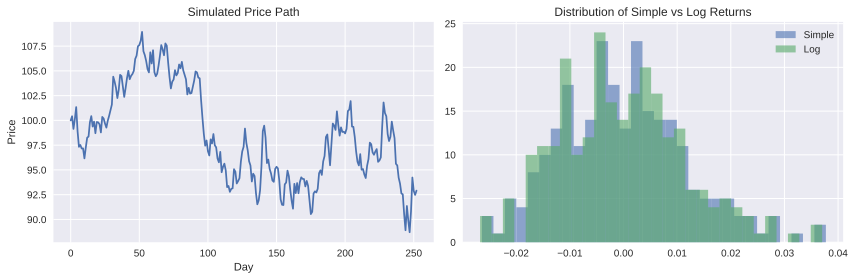

In [ ]:
T = 252   # trading days
mu = 0.10 # 10% annual drift
sigma = 0.2
dt = 1/252

# Simulate log-returns under a simple normal model
r = (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * rng.standard_normal(T)
log_returns = r

# Reconstruct prices from log-returns
P0 = 100.0
P = P0 * np.exp(np.cumsum(log_returns))
P = np.insert(P, 0, P0)  # include P0 at t=0

# Compute simple returns back from prices
simple_returns = P[1:] / P[:-1] - 1

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(P)
axes[0].set_title("Simulated Price Path")
axes[0].set_xlabel("Day")
axes[0].set_ylabel("Price")

axes[1].hist(simple_returns, bins=30, alpha=0.6, label="Simple")
axes[1].hist(log_returns, bins=30, alpha=0.6, label="Log")
axes[1].set_title("Distribution of Simple vs Log Returns")
axes[1].legend()
plt.tight_layout()
plt.show()

## 2. Geometric Brownian Motion (GBM)

In continuous time, GBM for an asset price $S_t $ is:

$dS_t = \mu S_t \, dt + \sigma S_t \, dW_t$

with closed-form solution:

$ S_t = S_0 \exp\left( \left(\mu - \tfrac{1}{2}\sigma^2\right)t + \sigma W_t \right),
$

where $ W_t $ is standard Brownian motion.

We'll simulate multiple GBM paths and visualize their distribution over time.


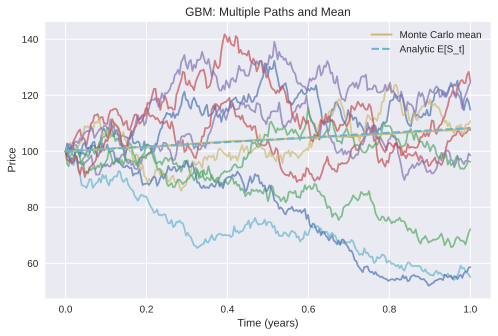

In [ ]:
S0 = 100
mu = 0.08
sigma = 0.25
T_years = 1.0
N = 252
M = 2000
dt = T_years / N

t = np.linspace(0, T_years, N + 1)
dW = rng.standard_normal((M, N)) * np.sqrt(dt)
W = np.concatenate([np.zeros((M, 1)), np.cumsum(dW, axis=1)], axis=1)

drift_term = (mu - 0.5 * sigma**2) * t
S = S0 * np.exp(drift_term + sigma * W)  # shape (M, N+1)

# Plot a few sample paths + mean
plt.figure(figsize=(8, 5))
for i in range(10):
    plt.plot(t, S[i], alpha=0.7)

S_mean_analytic = S0 * np.exp(mu * t)
plt.plot(t, S.mean(axis=0), lw=2, label="Monte Carlo mean")
plt.plot(t, S_mean_analytic, lw=2, ls="--", label="Analytic E[S_t]")
plt.title("GBM: Multiple Paths and Mean")
plt.xlabel("Time (years)")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

## 3. Portfolio Wealth Evolution

Let $\mathbf{r}_{t+1} $ be the **simple** return vector of $ n $ assets from $t $ to $ t+1 $,
and $\mathbf{w}_t $ portfolio weights (sum to 1).

- Portfolio return:
  $
  R^{(p)}_{t+1} = \mathbf{w}_t^\top \mathbf{r}_{t+1}
  $

- Wealth recursion:
  $
  V_{t+1} = V_t \left(1 + R^{(p)}_{t+1}\right)
  $

Below we simulate 3 correlated assets and track the wealth of a fixed-weight portfolio.


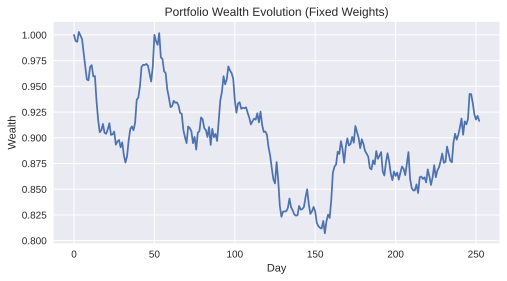

In [ ]:
T = 252
n_assets = 3
V0 = 1.0

# Toy parameters
mu_vec = np.array([0.08, 0.10, 0.12]) / 252   # daily drift
vol_vec = np.array([0.15, 0.20, 0.25])        # annual vol
rho = 0.6

# Build a simple covariance matrix with equal pairwise correlation rho
cov = np.diag(vol_vec**2)
for i in range(n_assets):
    for j in range(n_assets):
        if i != j:
            cov[i, j] = rho * vol_vec[i] * vol_vec[j]
cov_daily = cov / 252  # daily covariance

# Cholesky to generate correlated daily returns
L = np.linalg.cholesky(cov_daily)

Z = rng.standard_normal((T, n_assets))
daily_returns = mu_vec + Z @ L  # *simple* approx returns

# Choose fixed weights
w = np.array([0.3, 0.4, 0.3])

# Portfolio simple returns and wealth
R_p = (daily_returns @ w)
V = np.empty(T + 1)
V[0] = V0
for t in range(T):
    V[t+1] = V[t] * (1 + R_p[t])

plt.figure(figsize=(8, 4))
plt.plot(V)
plt.title("Portfolio Wealth Evolution (Fixed Weights)")
plt.xlabel("Day")
plt.ylabel("Wealth")
plt.grid(True)
plt.show()

## 4. Portfolio Mean, Variance, and Sharpe Ratio

Given expected returns $\boldsymbol{\mu} $ and covariance $\Sigma $ for $ n $ assets
and weights $\mathbf{w} $:

- Expected portfolio return:
  $
  \mu_p = \mathbf{w}^\top \boldsymbol{\mu}
  $

- Portfolio variance:
  $
  \sigma_p^2 = \mathbf{w}^\top \Sigma \mathbf{w}
  $

For excess returns, the Sharpe ratio is:
$
\text{Sharpe} = \frac{\mu_p}{\sigma_p}
$

Below we estimate $ \boldsymbol{\mu} $ and $ \Sigma $ from simulated returns and
compare theoretical vs empirical Sharpe.


In [ ]:
# Empirical per-day stats from the daily_returns we already simulated
mu_hat = daily_returns.mean(axis=0)
Sigma_hat = np.cov(daily_returns.T)

mu_p_theory = w @ mu_hat
sigma_p_theory = np.sqrt(w @ Sigma_hat @ w)

sharpe_theory_daily = mu_p_theory / sigma_p_theory
sharpe_theory_annual = np.sqrt(252) * sharpe_theory_daily

# Empirical portfolio returns from R_p
mu_p_emp = R_p.mean()
sigma_p_emp = R_p.std(ddof=1)
sharpe_emp_annual = np.sqrt(252) * mu_p_emp / sigma_p_emp

print(f"Theoretical annualized Sharpe (approx): {sharpe_theory_annual:.3f}")
print(f"Empirical    annualized Sharpe:        {sharpe_emp_annual:.3f}")

Theoretical annualized Sharpe (approx): -0.425
Empirical    annualized Sharpe:        -0.425


## 5. Transaction Costs and Turnover

Let $\mathbf{w}_t $ be current weights and $ \mathbf{w}_t^{\text{target}} $ target weights.
Define weight change:

$
\Delta \mathbf{w}_t = \mathbf{w}_t^{\text{target}} - \mathbf{w}_t
$

For a per-unit transaction cost $ c $, a simple linear cost model is:

$
\text{Cost}_t = c \sum_i \left|\Delta w_{t,i}\right|
$

The net portfolio return including costs becomes:

$
R^{(p,\text{net})}_{t+1} = \mathbf{w}_t^\top \mathbf{r}_{t+1} - \text{Cost}_t
$

Below we simulate a naive "rebalance to equal weight every $k$ days"
and see how costs eat into performance.


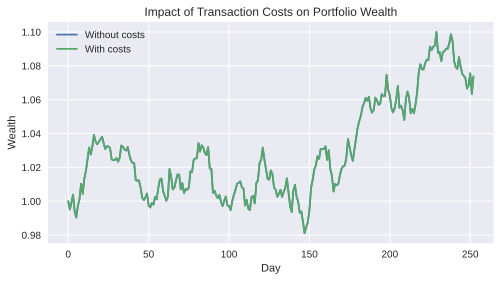

In [ ]:
T = 252
n_assets = 5
c = 0.0005   # 5 bps per 1.0 of turnover

# Simulate *independent* Gaussian returns for simplicity
mu_assets = np.linspace(0.05, 0.15, n_assets) / 252
sigma_assets = np.linspace(0.10, 0.25, n_assets)
Sigma_assets = np.diag((sigma_assets / np.sqrt(252))**2)

L_assets = np.linalg.cholesky(Sigma_assets)
Z = rng.standard_normal((T, n_assets))
R_assets = mu_assets + Z @ L_assets  # per-day simple returns

equal_w = np.ones(n_assets) / n_assets
w_t = equal_w.copy()
V_no_cost = np.empty(T + 1)
V_cost = np.empty(T + 1)
V_no_cost[0] = 1.0
V_cost[0] = 1.0

rebalance_every = 5

for t in range(T):
    # portfolio returns if we had weights w_t on day t
    R_p_t = w_t @ R_assets[t]

    # wealth update without cost
    V_no_cost[t+1] = V_no_cost[t] * (1 + R_p_t)

    # decide whether to rebalance
    if t % rebalance_every == 0:
        w_target = equal_w
    else:
        w_target = w_t

    # transaction cost based on weight change
    delta_w = w_target - w_t
    turnover = np.abs(delta_w).sum()
    cost_t = c * turnover

    R_p_net_t = R_p_t - cost_t
    V_cost[t+1] = V_cost[t] * (1 + R_p_net_t)

    # update weights to target
    w_t = w_target

plt.figure(figsize=(8, 4))
plt.plot(V_no_cost, label="Without costs")
plt.plot(V_cost, label="With costs")
plt.title("Impact of Transaction Costs on Portfolio Wealth")
plt.xlabel("Day")
plt.ylabel("Wealth")
plt.grid(True)
plt.legend()
plt.show()


## 6. Drawdown and Maximum Drawdown

Given a wealth curve $V_t $, define the running peak:

$
M_t = \max_{0 \le s \le t} V_s
$

Drawdown at time $t $:

$
\text{DD}_t = 1 - \frac{V_t}{M_t}
$

Maximum drawdown over the period:

$
\text{MDD} = \max_{0 \le t \le T} \text{DD}_t
$

Below we compute drawdowns for the `V_cost` series.


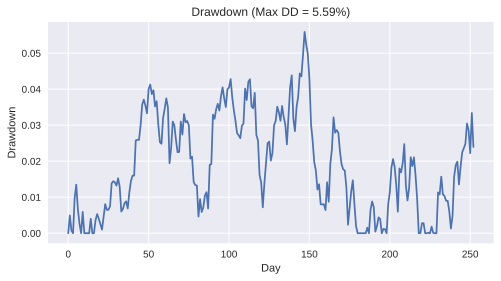

In [ ]:
V = pd.Series(V_cost)
running_max = V.cummax()
dd = 1 - V / running_max
mdd = dd.max()

plt.figure(figsize=(8, 4))
plt.plot(dd)
plt.title(f"Drawdown (Max DD = {mdd:.2%})")
plt.xlabel("Day")
plt.ylabel("Drawdown")
plt.grid(True)
plt.show()


## 7. Kelly Leverage Toy Experiment

For a strategy with mean excess return $\mu $ and variance $ \sigma^2 $ of returns,
a common approximation to the **Kelly fraction** is:

$
f^* \approx \frac{\mu}{\sigma^2}
$

If we lever the strategy by a factor $f $, the effective return is $ f R_t $.
We can simulate wealth for different leverage levels and see how going beyond Kelly
hurts long-run growth and drawdowns.


In [ ]:
T = 252 * 5  # 5 years
mu = 0.10 / 252
sigma = 0.20 / np.sqrt(252)

R_base = mu + sigma * rng.standard_normal(T)  # simple returns of base strategy

mu_hat = R_base.mean()
sigma2_hat = R_base.var(ddof=1)
f_kelly = mu_hat / sigma2_hat
f_kelly

np.float64(-1.750340331967982)

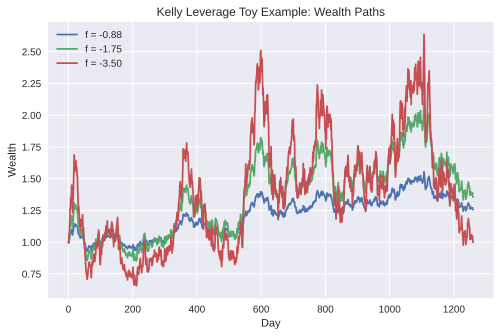

In [ ]:
leverage_levels = [0.5 * f_kelly, 1.0 * f_kelly, 2.0 * f_kelly]
wealth_paths = {}

for f in leverage_levels:
    V = np.empty(T + 1)
    V[0] = 1.0
    for t in range(T):
        V[t+1] = V[t] * (1 + f * R_base[t])
    wealth_paths[f] = V

plt.figure(figsize=(8, 5))
for f, V in wealth_paths.items():
    plt.plot(V, label=f"f = {f:.2f}")
plt.title("Kelly Leverage Toy Example: Wealth Paths")
plt.xlabel("Day")
plt.ylabel("Wealth")
plt.grid(True)
plt.legend()
plt.show()
